In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
from photutils import source_properties, properties_table
from photutils import DAOStarFinder
from photutils import detect_threshold
from photutils.segmentation import deblend_sources
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_threshold
from photutils import detect_sources
from astropy.convolution import Gaussian2DKernel
import Mask_Generatorplus as MGP
import Isophote as Iso
import Isophote_Substitution as Sub
import Get_Aperture as Ape
import deviation_calculator as DC
from astropy.visualization import MinMaxInterval,SqrtStretch,AsinhStretch
from photutils.utils import random_cmap
from astropy.visualization import LogStretch
from astropy.modeling import models, fitting
from scipy.interpolate import interp1d
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import aperture_photometry, CircularAperture, CircularAnnulus,EllipticalAperture,EllipticalAnnulus
from astropy.table import Table, Column
from matplotlib import patches 
from astropy.io import ascii
from scipy.optimize import brentq
import time

# Input data

In [2]:
magzp = 20.5
filepath='/Users/liruancun/Desktop/zmy/'
ra =2.472333333 
dec = 25.92436111
targname='test'
fitsname='test'
band='w1'
gain=3.2
psfFWHMArcsec=6.1

# Sky Subtraction

-----------------------------
Target: test
Band: w1
Zero point: 20.500
233


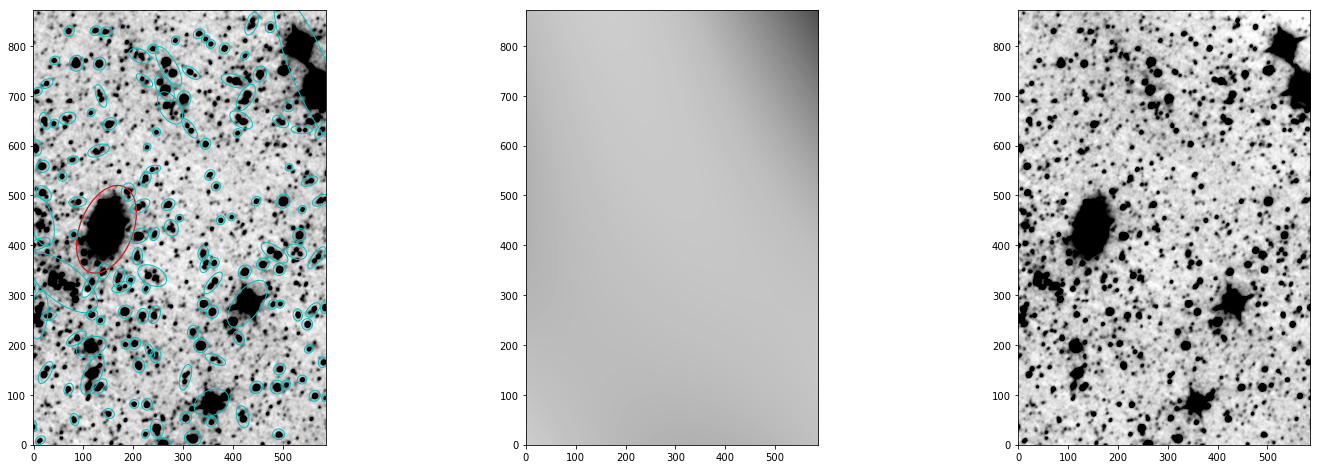

In [3]:
calibration=1.5
norm=ImageNormalize(AsinhStretch())
hduList = fits.open(filepath+fitsname+'.fits')
print ('-----------------------------')
print ('Target: {0}'.format(targname))
print ('Band: {0}'.format(band))
data_org = hduList[0].data
sky_mean, sky_median, sky_std = sigma_clipped_stats(data_org, sigma=3.0, iters=5)
header = hduList[0].header
pixelSize = abs(header['CDELT1']) * 3600.
print ('Zero point: {0:.3f}'.format(magzp))
psfFWHMpix = psfFWHMArcsec/pixelSize
wcs = WCS(header)
srcPstXY = wcs.all_world2pix([ra], [dec], 1)
srcXp = srcPstXY[0][0] 
srcYp = srcPstXY[1][0] 
posi=[srcXp,srcYp]
thresholder = detect_threshold(data_org, snr=3.0)  
sigma = psfFWHMpix * gaussian_fwhm_to_sigma    
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data_org, thresholder, npixels=5, filter_kernel=kernel)
plt.figure(figsize=(25,8))
plt.subplot(1,3,1)
plt.imshow(data_org-sky_median, origin='lower', cmap='Greys',norm=norm,vmin=(-2*sky_std),vmax=(100*sky_std))
ax=plt.gca()
props = source_properties(data_org, segm)
maskplus=np.zeros_like(data_org, dtype=bool)
maskplus[np.isnan(data_org)] = True
maskplus[np.isinf(data_org)] = True
tma=10.
tmb=10.
tmtheta=10.
found=True
number=None
keep=[]
for prop in props:
    peak=prop.max_value-sky_median
    if (peak > calibration):
        keep.append(prop.id)
segm.keep_labels(keep)
props = source_properties(data_org, segm)
magnification=3.5
for prop in props:
    position = (prop.xcentroid.value, prop.ycentroid.value)
    intposix=int(prop.xcentroid.value)
    intposiy=int(prop.ycentroid.value)
    a = prop.semimajor_axis_sigma.value 
    b = prop.semiminor_axis_sigma.value 
    theta = prop.orientation.value*180./np.pi
    maskRp=MGP.Maskellipse(maskplus,bool,position,magnification*a,(1-b/a),theta)
    maskplus=maskRp['mask']
    ellipseAp = patches.Ellipse(xy=position,width=7*a,height=7*b,angle=theta,color='c',fill=False)
    ax.add_patch(ellipseAp)
    if maskplus[int(srcYp)][int(srcXp)]&found:
        tma=a*magnification
        tmb=b*magnification
        tmtheta=theta
        number=prop.id
        found=False
        ellipseAp = patches.Ellipse(xy=position,width=7*a,height=7*b,angle=theta,color='r',fill=False)
        ax.add_patch(ellipseAp)
        print number
plt.subplot(1,3,2)
backR=MGP.polynomialfit(data_org,maskplus.astype(bool))
background=backR['bkg']
plt.imshow(background-sky_median, origin='lower', cmap='Greys',norm=norm,vmin=(-2*sky_std),vmax=(+4*sky_std))
data=data_org-background
plt.subplot(1,3,3)
plt.imshow(data, origin='lower', cmap='Greys',norm=norm,vmin=(-2*sky_std),vmax=(4*sky_std))
plt.show()
fitsname=targname+'SS{0}'.format(band)
After=hduList
After[0].data=data
After.writeto(filepath+targname+'SS{0}'.format(band)+".fits",overwrite= True)


# Source Deblending

40


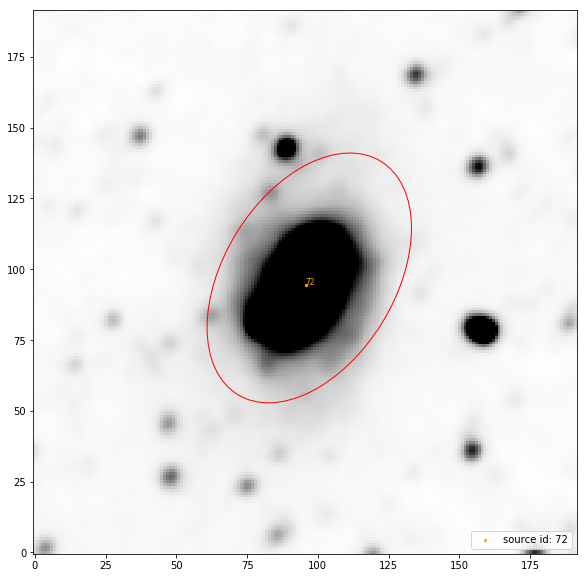

Please input the sources that you want to measure (0 for quit): 
72
Please input the sources that you want to measure (0 for quit): 
0
Please input the source that been identified incorrectly (0 for quit): 
0


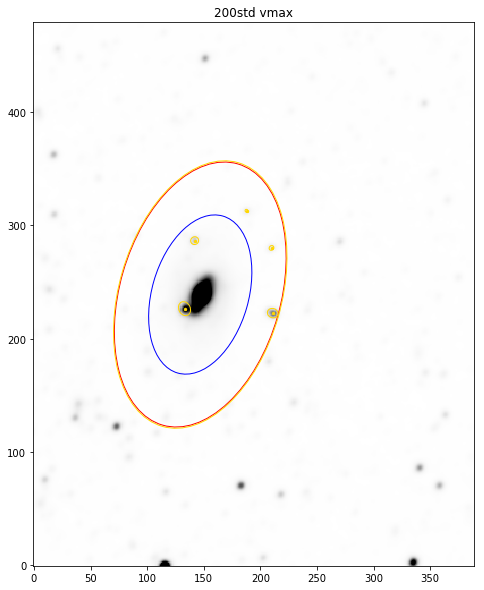

In [4]:
vmin=-2*sky_std
vmax=40*sky_std
A=(tma**2)*(np.sin(tmtheta))**2+(tmb**2)*(np.cos(tmtheta))**2
B=2*(tmb**2-tma**2)*np.sin(tmtheta)*np.cos(tmtheta)
C=(tma**2)*(np.cos(tmtheta))**2+(tmb**2)*(np.sin(tmtheta))**2
thresholder = detect_threshold(data, snr=3.0)
segm = detect_sources(data, thresholder, npixels=5, filter_kernel=kernel)
props = source_properties(data, segm)
maskplus=np.zeros_like(data_org, dtype=bool)
maskplus[np.isnan(data_org)] = True
maskplus[np.isinf(data_org)] = True
tma=10.
tmb=10.
tmtheta=10.
found=True
number=None
magnification=3.5
for prop in props:
    position = (prop.xcentroid.value, prop.ycentroid.value)
    intposix=int(prop.xcentroid.value)
    intposiy=int(prop.ycentroid.value)
    a = prop.semimajor_axis_sigma.value 
    b = prop.semiminor_axis_sigma.value 
    theta = prop.orientation.value*180./np.pi
    maskRp=MGP.Maskellipse(maskplus,bool,position,magnification*a,(1-b/a),theta)
    maskplus=maskRp['mask']
    if maskplus[int(srcYp)][int(srcXp)]&found:
        tma=a*magnification*1.5
        tmb=b*magnification*1.5
        tmtheta=theta
        number=prop.id
        found=False
        print number
segm2=deblend_sources(data,segm,5,filter_kernel=kernel,labels=number)
sour=source_properties(data,segm2)
sources=sour.to_table()
snames=sources.colnames
target=Table(names=snames)
fakesources=Table(names=snames)
localsourc=Table(names=snames)
maskcorrection=Table(names=snames)
nny,nnx=data.shape
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
intx=int(srcXp)
inty=int(srcYp)
radiint=int(2*tma)
minx=np.max([intx-radiint,0])
miny=np.max([inty-radiint,0])
maxx=np.min([intx+radiint,nnx-1])
maxy=np.min([inty+radiint,nny-1])
datalocal=data[miny:maxy,minx:maxx]
shift={
    'x':minx,
    'y':miny
}
plt.imshow(datalocal, cmap='Greys', origin='lower', norm=norm,vmin=vmin,vmax=vmax)
posi1=[srcXp-shift['x'],srcYp-shift['y']]
ellipse = patches.Ellipse(xy=posi1,width=2*tma,height=2*tmb,angle=tmtheta,color='r',fill=False)
ax.add_patch(ellipse)
cmap = MGP.get_cmap(10)
ccolor=1
localcount12=[]
for loop2 in range(len(sources)):
    centX = sources['xcentroid'][loop2].value
    centY = sources['ycentroid'][loop2].value
    psfdx=centX-srcXp
    psfdy=centY-srcYp      
    distan=A*psfdx**2+B*psfdx*psfdy+C*psfdy**2-(tma**2)*(tmb**2)
    if distan<0. :
        localsourc.add_row(sources[loop2])
        localcount12.append(sources['id'][loop2])
        c=cmap(ccolor)
        ccolor+=1
        plt.scatter(centX-shift['x'],centY-shift['y'], color =c, s = 5,label='source id: {0}'.format(sources['id'][loop2]))
        plt.text(centX-shift['x'],centY-shift['y'], "{0}".format(sources['id'][loop2]), size = 7.5, color = c, weight = "light" )
plt.legend(loc='lower right')
plt.show()
plt.close()
localcount=[]  
sample=False
while(sample is not True):
    sid=input('Please input the sources that you want to measure (0 for quit): \n')
    if(int(sid) == 0):
        sample=True
    else:
        ssid=int(sid)
        target.add_row(sources[ssid-1])
        localcount.append(ssid)
count0=0
lens1=len(localsourc)
for loop03 in range(lens1):
    if count0 == (len(localcount)):
        break
    for loop04 in range(len(localcount)):
        if localsourc['id'][loop03-count0] == localcount[loop04]:
            localsourc.remove_row(loop03-count0)
            count0 +=1 
fake=False
while(fake is not True):
    sid=input('Please input the source that been identified incorrectly (0 for quit): \n')
    if(int(sid) == 0):
        fake=True
    else :
        if(int(sid) == -1):
            fake=True
            fakesources=localsourc.copy()
            localcount=localcount12
        else:
            ssid=int(sid)
            fakesources.add_row(sources[ssid-1])
            localcount.append(ssid)
count1=0
otherSources=sources.copy()
for loop3 in range(len(sources)):
    if count1 == (len(localcount)):
        continue
    for loop4 in range(len(localcount)):
        if otherSources['id'][loop3-count1] == localcount[loop4]:
            otherSources.remove_row(loop3-count1)
            count1 +=1 
sourcecentercorrection=False
if sourcecentercorrection:
    target['xcentroid'][0]=srcXp
    target['ycentroid'][0]=srcYp
maxma=np.max([180,2.5*tma])
mask=np.zeros_like(data_org, dtype=bool)
mask[np.isnan(data_org)] = True
mask[np.isinf(data_org)] = True
for loop in range(len(otherSources)):
    position = (otherSources['xcentroid'][loop].value,otherSources['ycentroid'][loop].value)
    a = otherSources['semimajor_axis_sigma'][loop].value 
    b = otherSources['semiminor_axis_sigma'][loop].value 
    theta = otherSources['orientation'][loop].value*180./np.pi 
    if otherSources['max_value'][loop] > calibration :
        maskRp=MGP.Maskellipse(mask,bool,position,magnification*a,(1-b/a),theta)
        mask=maskRp['mask']
hdu = fits.PrimaryHDU(mask.astype('float32'))
hdulist = fits.HDUList([hdu])
label ='_'
hdulist.writeto(filepath+targname+'{0}{1}'.format(label,band)+'mask.fits', overwrite= True)
Iso.runellipse(filepath,targname,fitsname,target,maxsma=maxma,band=band,label=label,step=0.1,psfFWHM=psfFWHMpix,fflag=0.7)
isophote=ascii.read(filepath+targname+'{0}{1}'.format(label,band)+'.txt',
                        data_start=1)
thresholder=3.
result=Ape.get_aperture(data,isophote,gain,sigma=thresholder,mask=mask,QuietMode=True)
std=result['stdn']
a=np.max([1.6*isophote['col1'][std],120.] )   
b=a*( 1 - (isophote['col6'][std]) )
a0=result['sma']    
b0=result['b']
posi = [isophote['col10'][std], isophote['col12'][std]]              
theta=(isophote['col8'][std]+90)*np.pi/180
A=(a**2)*(np.sin(theta))**2+(b**2)*(np.cos(theta))**2
B=2*(b**2-a**2)*np.sin(theta)*np.cos(theta)
C=(a**2)*(np.cos(theta))**2+(b**2)*(np.sin(theta))**2
radiint=int(2*a)
minx=np.max([intx-radiint,1])
miny=np.max([inty-radiint,1])
maxx=np.min([intx+radiint,nnx-1])
maxy=np.min([inty+radiint,nny-1])
shift={
    'x':minx,
    'y':miny
}
posi2 = [result['posi'][0]-shift['x'], result['posi'][1]-shift['y']]
datalocal=data[miny:maxy,minx:maxx]
fig = plt.figure(figsize=(10, 10))
plt.title('200std vmax')
plt.imshow(datalocal, cmap='Greys', origin='lower', norm=norm,vmin=vmin,vmax=(sky_median+200*sky_std))
ax = plt.gca()
ellipseAp = patches.Ellipse(xy=posi2,width=2*a,height=2*b,angle=isophote['col8'][std]+90,color='r',fill=False)
ax.add_patch(ellipseAp)
ellipseAp = patches.Ellipse(xy=posi2,width=2*a0,height=2*b0,angle=isophote['col8'][std]+90,color='blue',fill=False)
ax.add_patch(ellipseAp)
a1=1.68*a0
b1=1.68*b0
ellipseAp = patches.Ellipse(xy=posi2,width=2*a1,height=2*b1,angle=isophote['col8'][std]+90,color='gold',fill=False)
ax.add_patch(ellipseAp)
A1=(a1**2)*(np.sin(theta))**2+(b1**2)*(np.cos(theta))**2
B1=2*(b1**2-a1**2)*np.sin(theta)*np.cos(theta)
C1=(a1**2)*(np.cos(theta))**2+(b1**2)*(np.sin(theta))**2
cmap = MGP.get_cmap(20)
ccolor=1
for loop2 in range (len(otherSources)):
    centX = otherSources['xcentroid'][loop2].value
    centY = otherSources['ycentroid'][loop2].value
    psfdx=centX-posi[0]
    psfdy=centY-posi[1] 
    position=[centX-shift['x'],centY-shift['y']]
    ap = otherSources['semimajor_axis_sigma'][loop2].value 
    bp = otherSources['semiminor_axis_sigma'][loop2].value 
    theta = otherSources['orientation'][loop2].value*180./np.pi 
    distan=A*psfdx**2+B*psfdx*psfdy+C*psfdy**2-(a**2)*(b**2)
    distan1=A1*psfdx**2+B1*psfdx*psfdy+C1*psfdy**2-(a1**2)*(b1**2)
    if centY-shift['y'] > 800.:
        print otherSources[loop2]
        break
    if (distan<0.): 
        if (distan1<0.):
            maskcorrection.add_row(otherSources[loop2])
            plt.scatter(centX-shift['x'],centY-shift['y'], color ='gold',marker='p', s = 7)
            ellipseAp = patches.Ellipse(xy=position,width=magnification*ap,height=magnification*bp,angle=theta,color='gold',fill=False)
            ax.add_patch(ellipseAp)
        else:
            c=cmap(ccolor)
            ccolor+=1
            plt.scatter(centX-shift['x'],centY-shift['y'], color =c, s = 5)       
            ellipseAp = patches.Ellipse(xy=position,width=2*magnification*ap,height=2*magnification*bp,angle=theta,color=c,fill=False)
            ax.add_patch(ellipseAp)
plt.savefig(filepath + targname + "_" + band + "pip.png", dpi=200)
plt.show()
plt.close() 
maskcorrection.write(filepath+targname+'{0}maskcorrection.ipac'.format(band),format="ascii.ipac", overwrite=True)            
otherSources.write(filepath+targname+'{0}otherSources.ipac'.format(band),format="ascii.ipac", overwrite=True)
target.write(filepath+targname+'{0}target.ipac'.format(band),format="ascii.ipac", overwrite=True)
fakesources.write(filepath+targname+'{0}fakesources.ipac'.format(band),format="ascii.ipac", overwrite=True)



# Aperture Determination

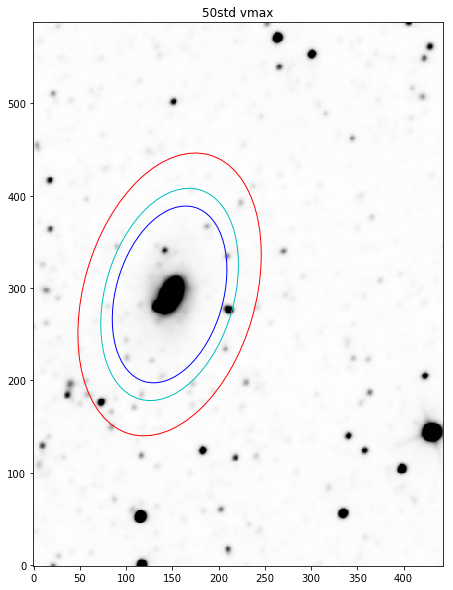

In [5]:
rebinning=False
mergerenlarge=False
hold1={
        'posi': result['posi'],
        'PA': result['PA']-90. ,
        'ellipticity': result['ellipticity'] ,
        'sma': 0.
    }
maxsma=np.max([1.6*result['sma'],180.])
Iso.runellipse(filepath,targname,fitsname,target,maxsma=maxsma,band=band,linear=False,label=label,step=0.05,psfFWHM=psfFWHMpix,shape=hold1)
isophote=ascii.read(filepath+targname+'{0}{1}'.format(label,band)+'.txt',
                        data_start=1)
if rebinning:
    rebinsky = DC.rebin_skypixelplus(data,maskplus.astype(bool),60,threshold=0.8)  
    threshold=rebinsky[1]/sky_std 
else:
    threshold=1.
annuluspath={
    'name': 'for_test',
    'savepath': filepath,
}
result=Ape.get_aperture(data,isophote,gain,mask=mask.astype(bool),sigma=threshold,QuietMode=False,imagepath=annuluspath)
if mergerenlarge & (len(target) == 2):
    hold1['sma']=1.5*result['sma']
    result=Ape.get_aperture(data,isophote,gain,mask=maskplus.astype(bool),sigma=threshold,QuietMode=False,imagepath=annuluspath,hold=hold1)
twoa=2*result['sma']    
twob=2*result['b']
posi = result['posi']              
theta=result['PA']*np.pi/180
radiint=int(1.5*twoa)
minx=np.max([intx-radiint,1])
miny=np.max([inty-radiint,1])
maxx=np.min([intx+radiint,nnx-1])
maxy=np.min([inty+radiint,nny-1])
shift={
    'x':minx,
    'y':miny
}
posi2 = [result['posi'][0]-shift['x'], result['posi'][1]-shift['y']]
datalocal=data[miny:maxy,minx:maxx]
fig = plt.figure(figsize=(10, 10))
plt.title('50std vmax')
plt.imshow(datalocal, cmap='Greys', origin='lower', norm=norm,vmin=vmin,vmax=(sky_median+50*sky_std))
ax = plt.gca()
ellipseAp = patches.Ellipse(xy=posi2,width=twoa,height=twob,angle=isophote['col8'][std]+90,color='b',fill=False)
ax.add_patch(ellipseAp)
ellipseAp = patches.Ellipse(xy=posi2,width=1.201*twoa,height=1.201*twob,angle=isophote['col8'][std]+90,color='c',fill=False)
ax.add_patch(ellipseAp)
ellipseAp = patches.Ellipse(xy=posi2,width=1.60*twoa,height=1.60*twob,angle=isophote['col8'][std]+90,color='r',fill=False)
ax.add_patch(ellipseAp)
plt.show()
sky=result['sky']
m=-2.5*np.log10((result['flux'])) + magzp 
m_err=2.5*result['flux_err']/(np.log(10)*result['flux'])
resu=[targname,band,threshold,result['posi'][0],result['posi'][1],twoa,twob,
      result['PA'],result['ellipticity'],result['flux'],result['flux_err']
      ,m,m_err,sky,result['sky_std'],pixelSize]



# Aperture Photometry

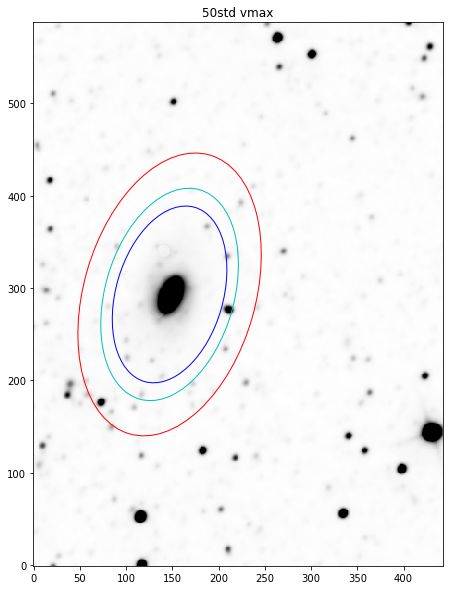

In [6]:
aperture={
        'posi': result['posi'],
        'PA': result['PA']-90. ,
        'ellipticity': result['ellipticity'],
        'sma': result['sma']
        }
expend=1.5-(aperture['sma']-40.)/500
expend=np.max([expend,1.05])
datafake=data.copy()
if (len(target) == 1) :
    maxsma=0.65*aperture['sma']
    Iso.runellipse(filepath,targname,fitsname,target,maxsma=maxsma,band=band,label=label,
                       step=0.1,linear=True,psfFWHM=psfFWHMpix,fflag=0.7)
    isophote2=ascii.read(filepath+targname+'{0}{1}'.format(label,band)+'.txt',
                            data_start=1,fill_values=[('INDEF','0')])
    datafake=Sub.maskclean(data,mask.astype(bool),isophote2,aperture,expend=expend)
else:
    otherSources2=otherSources
    target1=target.copy()
    target1.remove_row(1)
    target2=target.copy()
    target2.remove_row(0)
    rawa=0.5*raw['2a'][loop]
    rawb=0.5*raw['2b'][loop]
    dis1=np.sqrt((target1['xcentroid'][0].value-raw['X0'][loop])**2+(target1['ycentroid'][0].value-raw['Y0'][loop])**2)
    dis2=np.sqrt((target2['xcentroid'][0].value-raw['X0'][loop])**2+(target2['ycentroid'][0].value-raw['Y0'][loop])**2)
    dis0=np.sqrt((target2['xcentroid'][0].value-target1['xcentroid'][0].value)**2+(target2['ycentroid'][0].value-target1['ycentroid'][0].value)**2)
    maxsma1=(1.3/(1-raw['ellipticity'][loop]))*np.max([np.sqrt(dis1**2+rawb**2),(rawa-dis1)])
    maxsma2=(1.3/(1-raw['ellipticity'][loop]))*np.max([np.sqrt(dis2**2+rawb**2),(rawa-dis2)])
    Iso.runellipse(filepath,targname,fitsname,target1,maxsma=maxsma1,band=band,label=label,
                           step=0.05,linear=False,psfFWHM=psfFWHMpix)
    isophote1=ascii.read(filepath+targname+'{0}{1}'.format(label)+'.txt',
                                data_start=1,fill_values=[('INDEF','0')])
    Iso.runellipse(filepath,targname,fitsname,target2,maxsma=maxsma2,band=band,label=label,
                           step=0.05,linear=False,psfFWHM=psfFWHMpix)
    isophote2=ascii.read(filepath+targname+'{0}{1}'.format(label)+'.txt',
                                data_start=1,fill_values=[('INDEF','0')])
    the=20.
    if np.min(isophote1['col2']-sky_median) > 20.*sky_std:
        the = 1.2*np.min(isophote1['col2']-sky_median)/sky_std
    result1=Ape.get_aperture(data,isophote1,gain,mask=mask.astype(bool),sigma=the)
    the=20.
    if np.min(isophote2['col2']-sky_median) > 20.*sky_std:
        the = 1.2*np.min(isophote2['col2']-sky_median)/sky_std
    result2=Ape.get_aperture(data,isophote2,gain,mask=mask.astype(bool),sigma=the)
    hold1={
            'posi':result1['posi'] ,
            'PA': result1['paY'] ,
            'ellipticity': result1['ellipticity'] ,
            'sma': 0.
        }
    hold2={
            'posi':result2['posi'] ,
            'PA': result2['paY'] ,
            'ellipticity': result2['ellipticity'] ,
            'sma': 0.
        }
    if hold1['PA'] < -90. :
        hold1['PA'] += 180.
    if hold2['PA'] < -90. :
        hold2['PA'] += 180.
    dis1=np.sqrt((hold1['posi'][0]-aperture['posi'][0])**2+(hold1['posi'][1]-aperture['posi'][1])**2)
    sma1=(1.0/(1-hold1['ellipticity']))*np.max([np.sqrt(dis1**2+rawb**2),(rawa-dis1)])
    ssma1=np.min([np.sqrt(dis1**2+rawb**2),(rawa-dis1),2*result1['sma'],0.5*dis0])
    hold1['sma']=sma1
    dis2=np.sqrt((hold2['posi'][0]-aperture['posi'][0])**2+(hold2['posi'][1]-aperture['posi'][1])**2)
    sma2=(1.0/(1-hold2['ellipticity']))*np.max([np.sqrt(dis2**2+rawb**2),(rawa-dis2)])
    ssma2=np.min([np.sqrt(dis2**2+rawb**2),(rawa-dis2),2*result2['sma'],0.5*dis0])
    hold2['sma']=sma2
    mask1R=MGP.Maskellipse(mask,bool,result1['posi'],ssma1,result1['ellipticity'],result1['PA'])
    mask2R=MGP.Maskellipse(mask,bool,result2['posi'],ssma2,result2['ellipticity'],result2['PA'])
    mask1=mask1R['mask']
    mask2=mask2R['mask']
    plt.figure(figsize=(20, 10))
    plt.subplot(1,2,1)
    ax1=plt.gca()
    ellipseAp1 = patches.Ellipse(xy=aperture['posi'],width=2*aperture['sma'],height=raw['2b'][loop],angle=raw['PA'][loop],color='r',fill=False)
    ax1.add_patch(ellipseAp1)
    ellipseAp1 = patches.Ellipse(xy=hold1['posi'],width=2*ssma1,height=2*ssma1*(1-hold1['ellipticity']),angle=result1['PA'],color='b',fill=False)
    ax1.add_patch(ellipseAp1)
    ellipseAp1 = patches.Ellipse(xy=hold2['posi'],width=2*ssma2,height=2*ssma2*(1-hold2['ellipticity']),angle=result2['PA'],color='b',fill=False)
    ax1.add_patch(ellipseAp1)
    plt.imshow(data_org, cmap='Greys', origin='lower', norm=norm,vmin=-2*sky_std,vmax=50*sky_std)
    plt.subplot(1,2,2)
    ax2=plt.gca()
    ellipseAp1 = patches.Ellipse(xy=aperture['posi'],width=2*expend*aperture['sma'],height=expend*raw['2b'][loop],angle=raw['PA'][loop],color='r',fill=False)
    ax2.add_patch(ellipseAp1)
    ellipseAp1 = patches.Ellipse(xy=hold1['posi'],width=2*expend*sma1,height=2*expend*sma1*(1-hold1['ellipticity']),angle=result1['PA'],color='b',fill=False)
    ax2.add_patch(ellipseAp1)
    ellipseAp1 = patches.Ellipse(xy=hold2['posi'],width=2*expend*sma2,height=2*expend*sma2*(1-hold2['ellipticity']),angle=result2['PA'],color='b',fill=False)
    ax2.add_patch(ellipseAp1)
    plt.imshow(data_org, cmap='Greys', origin='lower', norm=norm,vmin=-2*sky_std,vmax=50*sky_std)
    plt.savefig(maskpath['savepath']+targname+band+'{0}+.png'.format(ID[loop]),dpi=200)
    plt.close()
    Iso.runellipse(filepath,targname,fitsname,target1,maxsma=(expend+0.05)*sma1,band=band,label=label,
                           step=1.,linear=True,psfFWHM=psfFWHMpix,shape=hold1)
    isophote1=ascii.read(filepath+targname+'{0}{1}'.format(label,band)+'.txt',
                                data_start=1,fill_values=[('INDEF','0')])
    hdu = fits.PrimaryHDU(mask1.astype('float32'))
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(filepath+targname+'{0}{1}'.format(label,band)+'mask.fits', overwrite= True)
    Iso.runellipse(filepath,targname,fitsname,target2,maxsma=(expend+0.05)*sma2,band=band,label=label,
                           step=1.,linear=True,psfFWHM=psfFWHMpix,shape=hold2)
    isophote2=ascii.read(filepath+targname+'{0}{1}'.format(label,band)+'.txt',
                                data_start=1,fill_values=[('INDEF','0')])
    datafake=Sub.mergermaskclean(data,mask.astype(bool),isophote1,isophote2,aperture,expend=expend)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(data_org, cmap='Greys', origin='lower', norm=norm,vmin=-2*sky_std,vmax=50*sky_std)
    ax1=plt.gca()
    ellipseAp1 = patches.Ellipse(xy=aperture['posi'],width=2*aperture['sma'],height=raw['2b'][loop],angle=raw['PA'][loop],color='r',fill=False)
    ax1.add_patch(ellipseAp1)
    ellipseAp1 = patches.Ellipse(xy=hold1['posi'],width=2*ssma1,height=2*ssma1*(1-hold1['ellipticity']),angle=result1['PA'],color='b',fill=False)
    ax1.add_patch(ellipseAp1)
    ellipseAp1 = patches.Ellipse(xy=hold2['posi'],width=2*ssma2,height=2*ssma2*(1-hold2['ellipticity']),angle=result2['PA'],color='b',fill=False)
    ax1.add_patch(ellipseAp1)
    plt.title('Before cleaning')
    plt.subplot(1, 2, 2)
    plt.imshow(data, cmap='Greys', origin='lower', norm=norm,vmin=-2*sky_std,vmax=50*sky_std)
    ax2=plt.gca()
    ellipseAp1 = patches.Ellipse(xy=aperture['posi'],width=2*aperture['sma'],height=raw['2b'][loop],angle=raw['PA'][loop],color='r',fill=False)
    ax2.add_patch(ellipseAp1)
    plt.title('After cleaning')
    plt.savefig(maskpath['savepath']+targname+band+'{0}.png'.format(ID[loop]),dpi=200)
    plt.close()
MASK=MGP.Maskellipse(mask.astype(bool),bool,aperture['posi'],expend*aperture['sma'],aperture['ellipticity'],aperture['PA']+90.,antimask=True)
mask=MASK['mask']
hdu = fits.PrimaryHDU(mask.astype('float32'))
hdulist = fits.HDUList([hdu])
hdulist.writeto(filepath+targname+'F{0}'.format(band)+'mask.fits', overwrite= True)
fitsname=targname+'F{0}'.format(band)
After=hduList
After[0].data=data
After.writeto(filepath+targname+'F{0}'.format(band)+".fits",overwrite= True)
result=Ape.get_aperture(data,isophote2,gain,mask=maskplus.astype(bool),hold=aperture)
twoa=2*result['sma']
twob=twoa*(1-result['ellipticity'])
posi = result['posi']              
theta=result['PA']*np.pi/180
radiint=int(1.5*twoa)
minx=np.max([intx-radiint,1])
miny=np.max([inty-radiint,1])
maxx=np.min([intx+radiint,nnx-1])
maxy=np.min([inty+radiint,nny-1])
shift={
    'x':minx,
    'y':miny
}
posi2 = [result['posi'][0]-shift['x'], result['posi'][1]-shift['y']]
datalocal=datafake[miny:maxy,minx:maxx]
fig = plt.figure(figsize=(10, 10))
plt.title('50std vmax')
plt.imshow(datalocal, cmap='Greys', origin='lower', norm=norm,vmin=vmin,vmax=(sky_median+50*sky_std))
ax = plt.gca()
ellipseAp = patches.Ellipse(xy=posi2,width=twoa,height=twob,angle=isophote['col8'][std]+90,color='b',fill=False)
ax.add_patch(ellipseAp)
ellipseAp = patches.Ellipse(xy=posi2,width=1.201*twoa,height=1.201*twob,angle=isophote['col8'][std]+90,color='c',fill=False)
ax.add_patch(ellipseAp)
ellipseAp = patches.Ellipse(xy=posi2,width=1.60*twoa,height=1.60*twob,angle=isophote['col8'][std]+90,color='r',fill=False)
ax.add_patch(ellipseAp)
plt.show()
sky=result['sky']
m=-2.5*np.log10((result['flux'])) + magzp
m_err=2.5*result['flux_err']/(np.log(10)*result['flux'])
resu2=[targname,band,threshold,result['posi'][0],result['posi'][1],twoa,twob,
      result['PA'],result['ellipticity'],result['flux'],result['flux_err']
      ,m,m_err,sky,result['sky_std'],pixelSize]



# Uncertainty Estimation

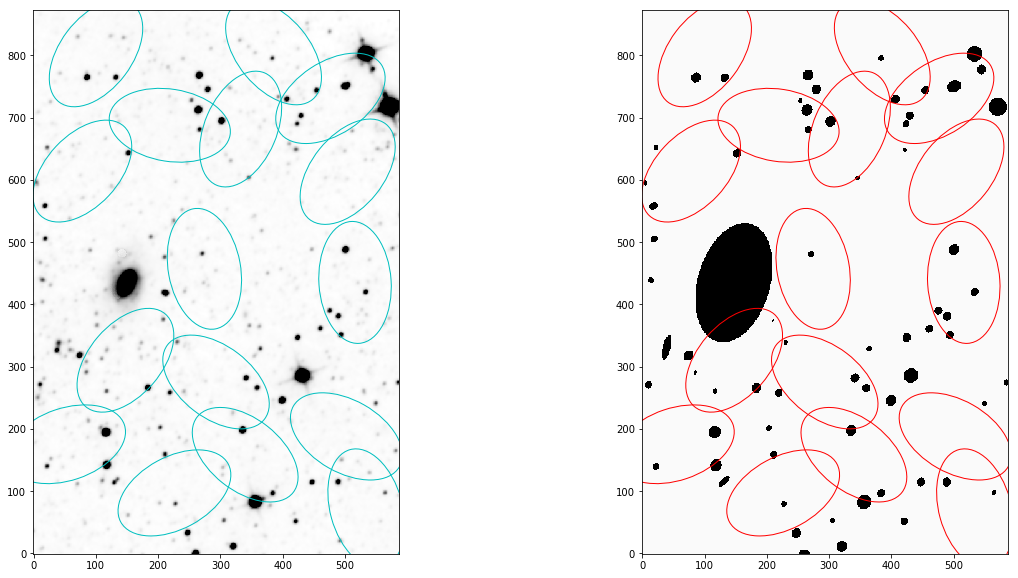

In [8]:

sigpath=filepath
signame = 'testsig'
sighdu=fits.open(sigpath+signame+'.fits')
sigmamap=sighdu[0].data
a=aperture['sma']
f_cor= ascii.read(filepath+'test.txt',data_start=0)
F_corr = interp1d(f_cor['col1'], f_cor['col2']) 
Ma_corr=np.max(f_cor['col1'])
List_corr=f_cor
F=F_corr
b=a*(1-aperture['ellipticity'])
maskRp=MGP.Maskellipse(mask.astype(bool),bool,aperture['posi'],result['sma'],result['ellipticity'],result['PA'])
maskPLUS=maskRp['mask']
isophote=None
APE=Ape.sampler(maskPLUS,aperture)
L=List_corr
if a > Ma_corr:
    Fcorr=L['col2'][len(L)-1]
else:
    Fcorr=F(a)
sky_mean, sky_median, sky_std = sigma_clipped_stats(datafake, sigma=3.0, iters=5)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(datafake, cmap='Greys', origin='lower', norm=norm,vmin=(-2*sky_std),vmax=(+50*sky_std))
ax1=plt.gca()
for ape in APE:
    ellipseAp = patches.Ellipse(xy=ape.posi,width=2*a,height=2*b,angle=ape.PA+90,color='c',fill=False)
    ax1.add_patch(ellipseAp)
plt.subplot(1,2,2)
plt.imshow(100*maskPLUS, cmap='Greys', origin='lower', norm=norm,vmin=(-2*sky_std),vmax=(+50*sky_std))
ax2=plt.gca()
for ape in APE:
    ellipseAp = patches.Ellipse(xy=ape.posi,width=2*a,height=2*b,angle=ape.PA+90,color='r',fill=False)
    ax2.add_patch(ellipseAp)
plt.savefig(filepath+'sampler'+targname+band+'.png',dpi=200)
plt.show()
plt.close()
sigma=Ape.WISEuncertainty(datafake,band,maskPLUS,sigmamap,aperture,APE,Fcorr,result['flux'],magzp)
resul=[loop,targname,band,len(APE),sigma['flux'],sigma['sig_src'],sigma['mag'],sigma['sig_mag'],sigma['sig_pixel'],sigma['sig_sky'],sigma['sig_conf'] ]

